# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from desicision_tree import DecisionTree, find_best_split
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    ('Circles', make_circles(noise=0.2, factor=0.5, random_state=42)),
    ('Moons', make_moons(noise=0.2, random_state=42)),
    ('Classification', make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, ))
]

In [ ]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

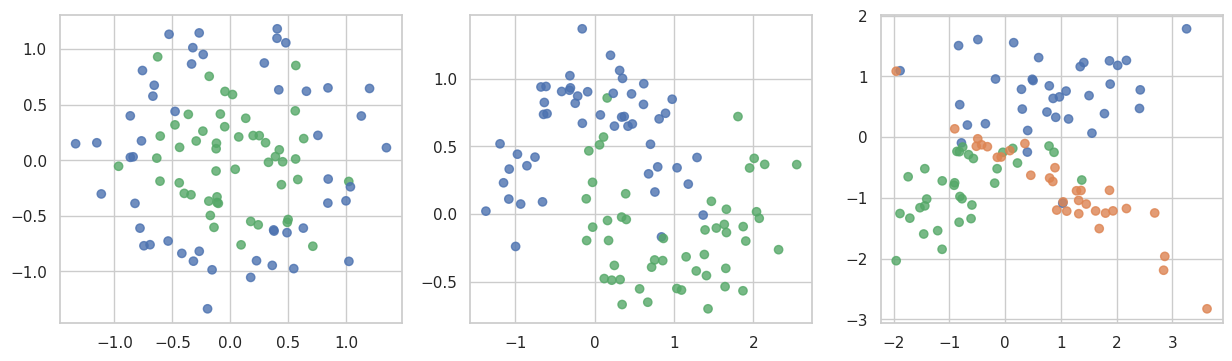

In [ ]:
plt.figure(figsize=(15, 4))
for i, (name, (x, y)) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [ ]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

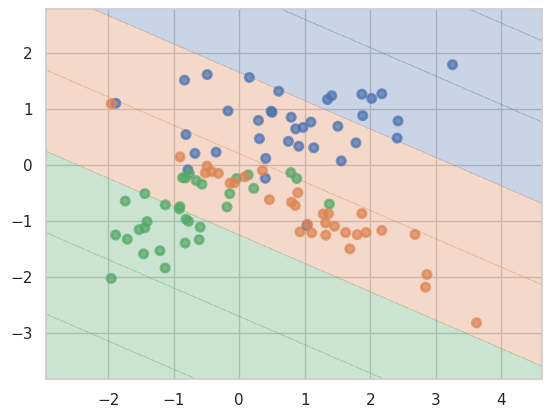

In [ ]:
# Пример:
from sklearn.linear_model import LinearRegression
((name), (X, y)) = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

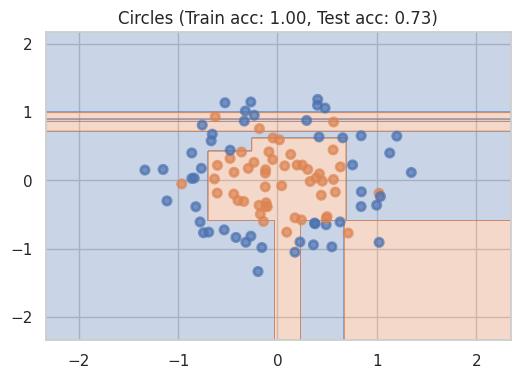

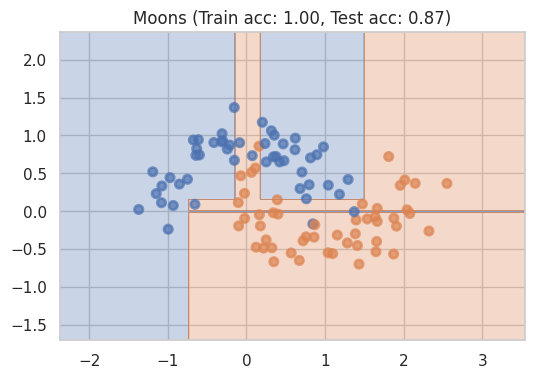

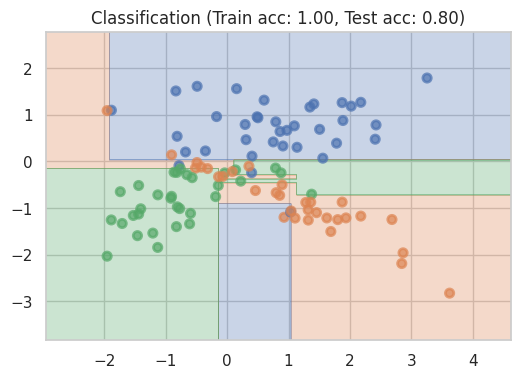

In [ ]:
for (name, (X, y)) in datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))

    plt.figure(figsize=(6, 4))
    plot_surface(clf, X, y)
    plt.title(f"{name} (Train acc: {train_acc:.2f}, Test acc: {test_acc:.2f})")
    plt.show()

__Ответ:__ На всех трёх графиках решающие деревья показывают идеальную точность на обучении (1.00), но на тесте (0.77, 0.87, 0.80), что указывает на переобучение. Разделяющие границы слишком сложные, особенно в областях с редкими точками, что подтверждает избыточную подстройку под обучающие данные.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

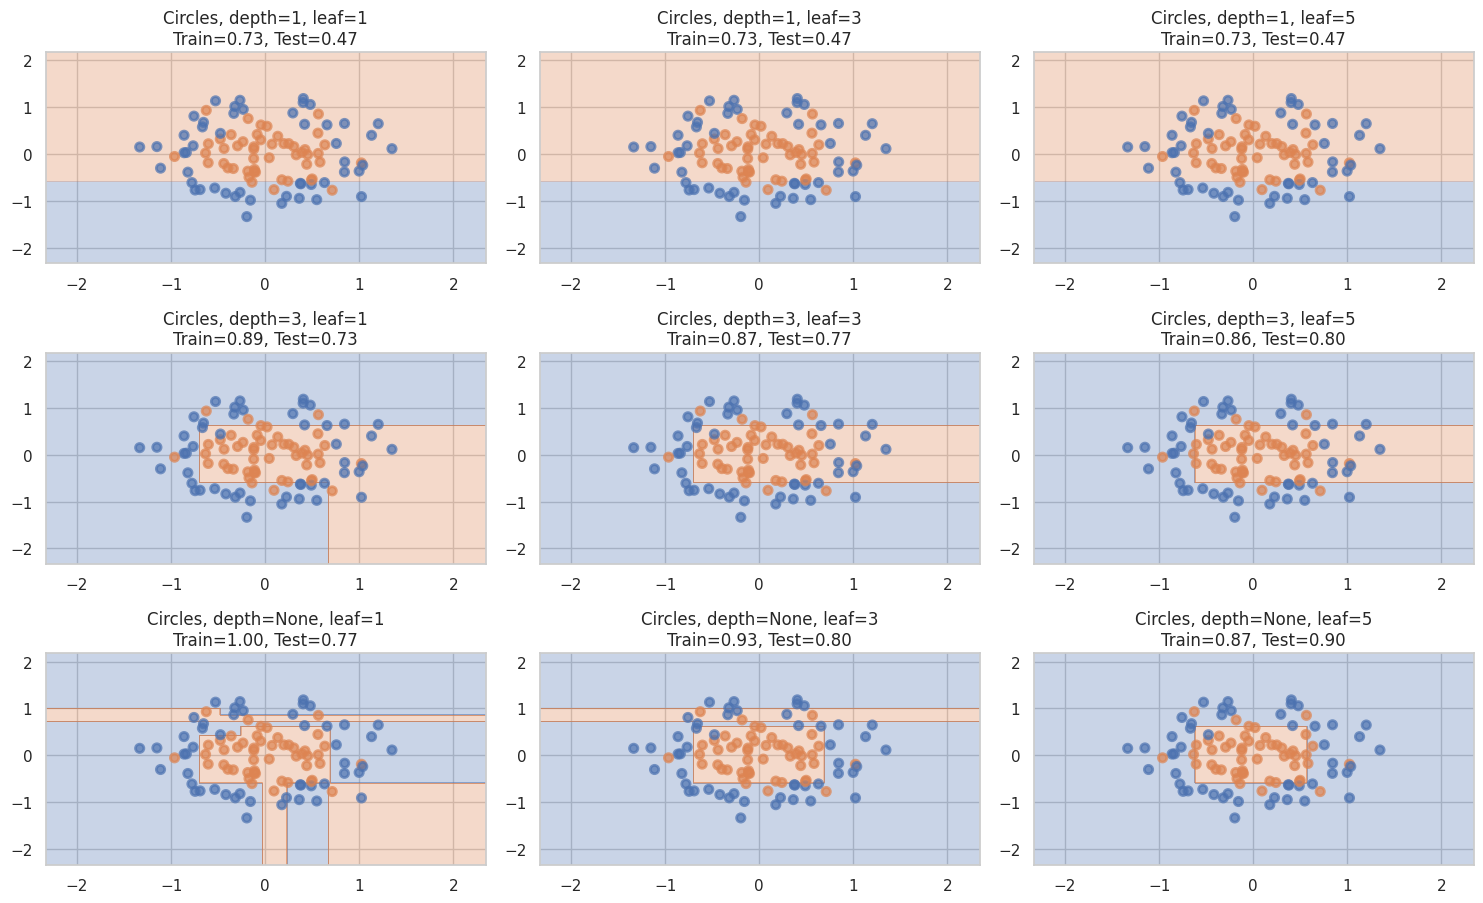

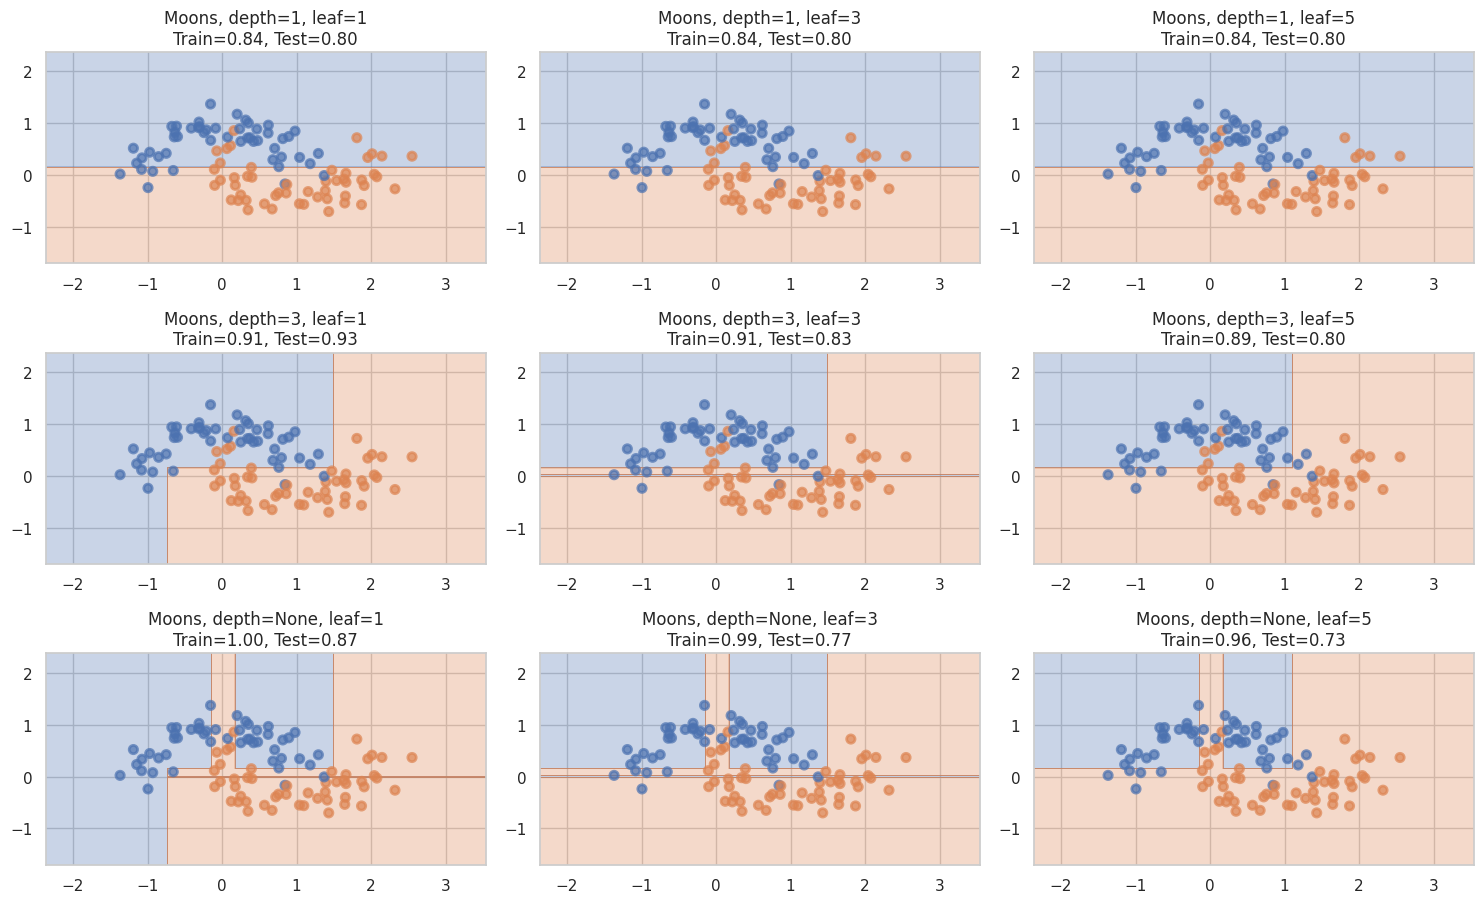

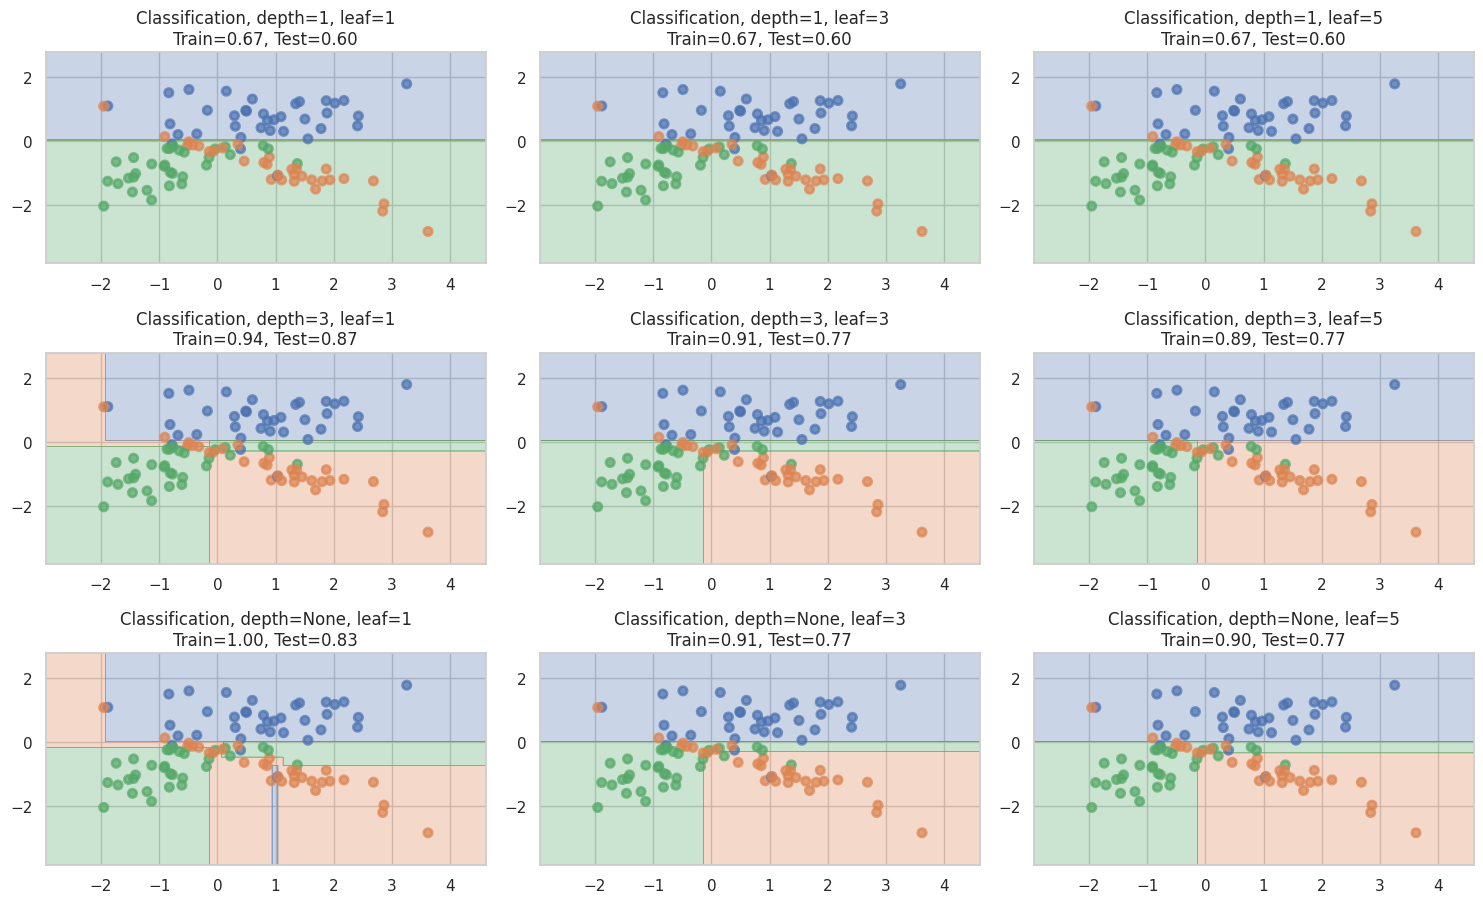

In [ ]:
depths = [1, 3, None]
leafs = [1, 3, 5]
for (name, (X, y)) in datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    fig, axes = plt.subplots(len(depths), len(leafs), figsize=(15, 10))
    for i, max_depth in enumerate(depths):
        for j, min_samples_leaf in enumerate(leafs):
            clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=0)
            clf.fit(X_train, y_train)

            train_acc = accuracy_score(y_train, clf.predict(X_train))
            test_acc = accuracy_score(y_test, clf.predict(X_test))

            ax = axes[i, j]
            plt.sca(ax)
            plot_surface(clf, X, y)
            ax.set_title(f"{name}, depth={max_depth}, leaf={min_samples_leaf}\nTrain={train_acc:.2f}, Test={test_acc:.2f}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

__Ответ:__ При малой глубине границы решений простые (горизонтальные/вертикальные линии), что приводит к недообучению (низкая точность на train и test).

С увеличением границы становятся сложными, повторяя форму данных, но при depth=None переобучение (высокая точность на train, но падение на test).

Полное отсутствие ограничений (depth=None) ухудшает обобщение

Classification: Чувствителен к глубине — уже при depth=3 переобучается.

Circles: Требует глубоких деревьев (depth=None) с большим кол-ом листьев (Test=0.90 при leaf=5).

Moons: Оптимален при depth=3 (Test=0.93), дальнейшее усложнение вредит.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [ ]:
data = pd.read_csv('datasets/students.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

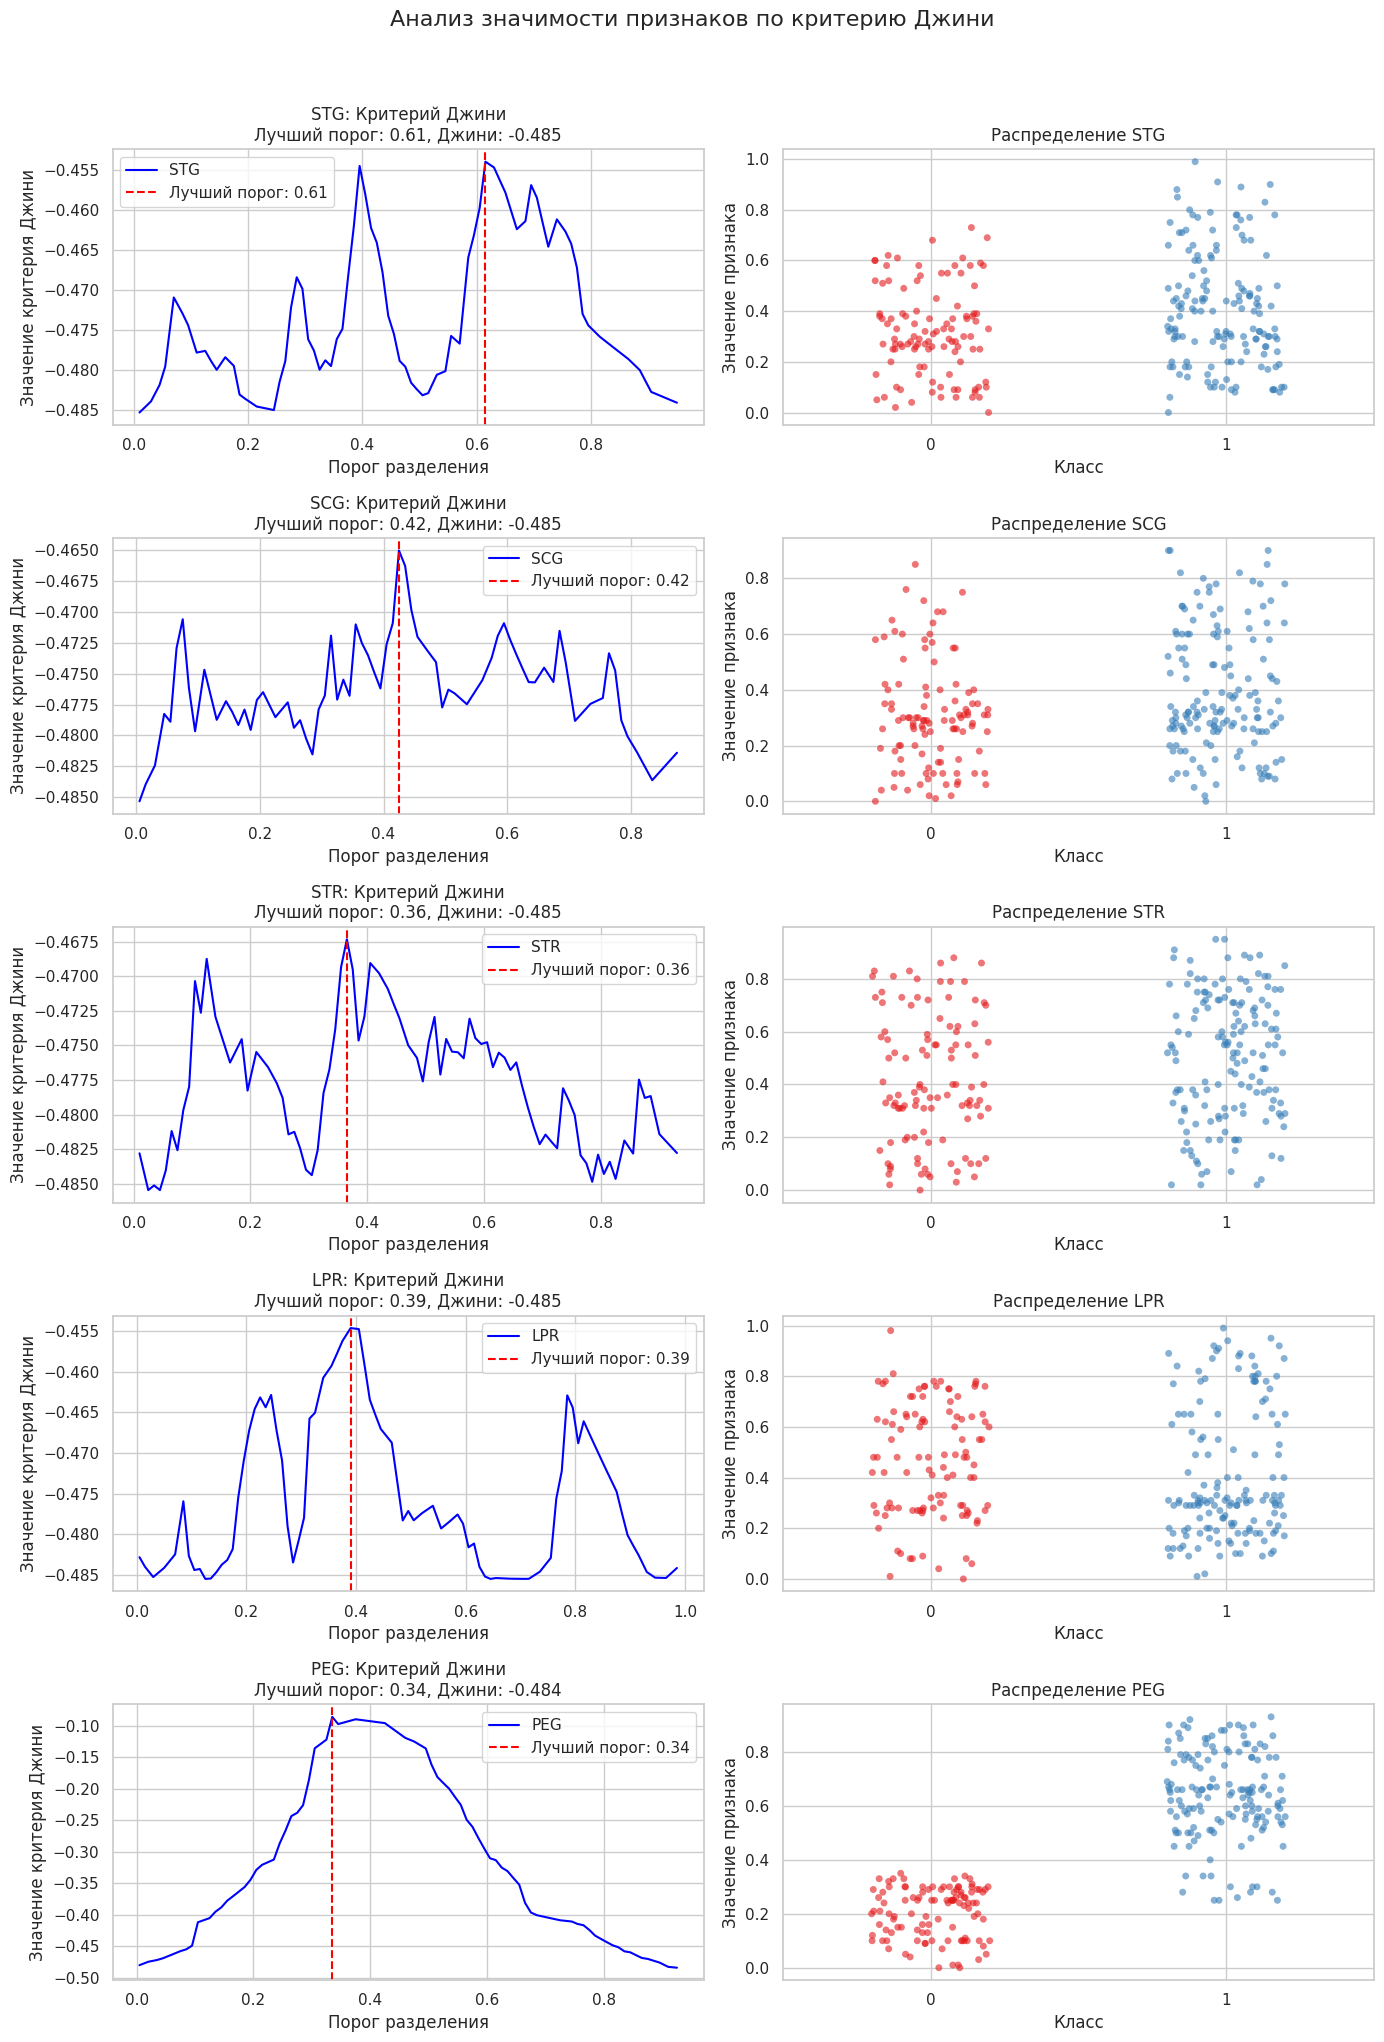

In [ ]:
feature_names = data.columns[:-1].tolist()

fig, axes = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle("Анализ значимости признаков по критерию Джини", fontsize=16, y=1.02)

for i in range(5):
    feature_vector = X[:, i]
    thresholds, ginis, threshold_best, gini_best = find_best_split(feature_vector, y)

    ax_gini = axes[i, 0]
    ax_gini.plot(thresholds, ginis, label=f'{feature_names[i]}', color='blue')
    ax_gini.axvline(threshold_best, color='red', linestyle='--', label=f'Лучший порог: {threshold_best:.2f}')
    ax_gini.set_title(f'{feature_names[i]}: Критерий Джини\nЛучший порог: {threshold_best:.2f}, Джини: {min(ginis):.3f}')
    ax_gini.set_xlabel('Порог разделения')
    ax_gini.set_ylabel('Значение критерия Джини')
    ax_gini.legend()

for i in range(5):
    feature_vector = X[:, i]

    ax = axes[i, 1]
    sns.stripplot(x=y, y=feature_vector, ax=ax, palette='Set1', jitter=0.2, alpha=0.6)
    ax.set_title(f'Распределение {feature_names[i]}')
    ax.set_xlabel('Класс')
    ax.set_ylabel('Значение признака')
    ax.grid(True)

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Разделение выборки следует производить по признаку, у которого значение критерия Джини достигает наименьшего минимума — т.е. максимум по качеству разбиения(на графике как глубокая и резкая впадина, соответствующая чёткому разделению классов). Такой результат, как правило, согласуется со scatter-графиком: значения признака для разных классов почти не перекрываются.
У "хороших" признаков кривая Джини имеет отчётливо выраженный минимум, тогда как у "плохих" признаков она либо плоская, либо колеблется без выраженного экстремума — это указывает на шумное разделение.
То есть в нашем случае PEG - лучший признак по критерию Джини.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [46]:
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment",
    "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root",
    "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
    "spore-print-color", "population", "habitat"
]

df_mushrooms = pd.read_csv('datasets/agaricus-lepiota.data', names=columns)

le = LabelEncoder()
encoded_data = df_mushrooms.apply(le.fit_transform)

X = encoded_data.drop('class', axis=1).values
y = encoded_data['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

my_tree = DecisionTree(['categorical'] * X.shape[1])
my_tree.fit(X_train, y_train)

predictions = my_tree.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 1.0000


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

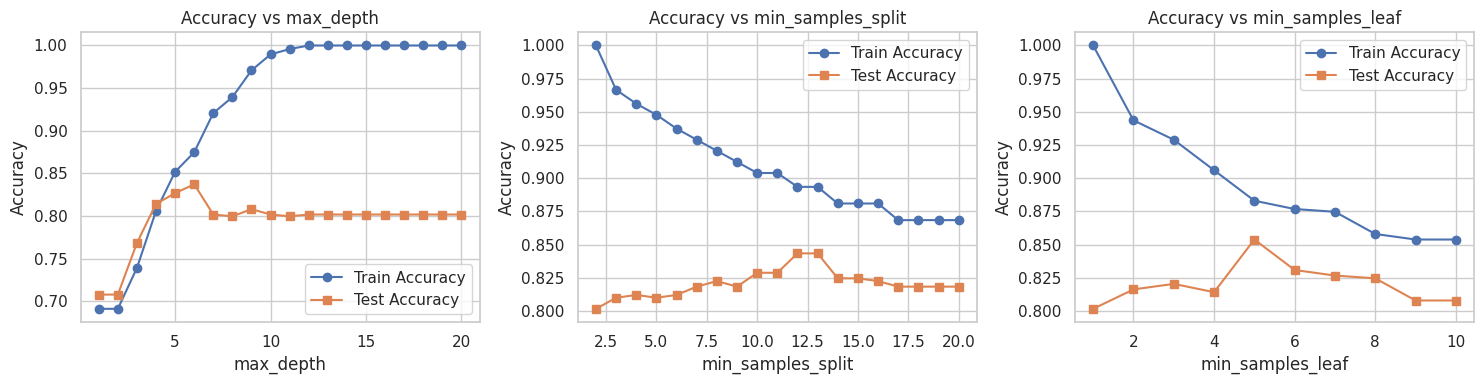

In [47]:
df_tictactoe_endgame = pd.read_csv("datasets/tic-tac-toe-endgame.csv")

le = LabelEncoder()
encoded_data = df_tictactoe_endgame.apply(le.fit_transform)

X = encoded_data.drop('V10', axis=1).values
y = encoded_data['V10'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

feature_types = ["categorical"] * X.shape[1]
def test_param_range(param_name, param_values):
    train_accuracies = []
    test_accuracies = []

    for val in param_values:
        kwargs = {param_name: val}
        tree = DecisionTree(feature_types, **kwargs)
        tree.fit(X_train, y_train)

        y_train_pred = tree.predict(X_train)
        train_acc = accuracy_score(y_train, y_train_pred)
        train_accuracies.append(train_acc)

        y_test_pred = tree.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_accuracies.append(test_acc)

    return train_accuracies, test_accuracies

plt.figure(figsize=(15, 4))

param_ranges = {
    "max_depth": range(1, 21),
    "min_samples_split": range(2, 21),
    "min_samples_leaf": range(1, 11)
}

for i, (param, values) in enumerate(param_ranges.items()):
    plt.subplot(1, 3, i + 1)
    train_accs, test_accs = test_param_range(param, values)
    plt.plot(values, train_accs, label="Train Accuracy", marker='o')
    plt.plot(values, test_accs, label="Test Accuracy", marker='s')
    plt.xlabel(param)
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs {param}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [36]:
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)
df_mushrooms = pd.read_csv('datasets/agaricus-lepiota.data', names=columns)
df_tictactoe_endgame = pd.read_csv("datasets/tic-tac-toe-endgame.csv")

le = LabelEncoder()
encoded_data = df_mushrooms.apply(le.fit_transform)

X_mshrms = encoded_data.drop('class', axis=1).values
y_mshrms = encoded_data['class'].values

encoded_data = df_tictactoe_endgame.apply(le.fit_transform)

X_ttt = encoded_data.drop('V10', axis=1).values
y_ttt = encoded_data['V10'].values

encoded_cars = cars.copy()

encoded_cars.iloc[:, :-1] = encoded_cars.iloc[:, :-1].apply(le.fit_transform)
encoded_cars[6] = encoded_cars[6].map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})

X_cars = encoded_cars.iloc[:, :-1].values
y_cars = encoded_cars[6].values

encoded_nursery = nursery.copy()

encoded_nursery.iloc[:, :-1] = encoded_nursery.iloc[:, :-1].apply(le.fit_transform)
encoded_nursery[8] = encoded_nursery[8].map({
    'not_recom': 0,
    'recommend': 0,
    'very_recom': 1,
    'priority': 1,
    'spec_prior': 1
})

X_nursery = encoded_nursery.iloc[:, :-1].values
y_nursery = encoded_nursery[8].values

#---------------
datasets = ['mushrooms', 'tic-tac-toe', 'cars', 'nursery']
X_list = [X_mshrms, X_ttt, X_cars, X_nursery]
y_list = [y_mshrms, y_ttt, y_cars, y_nursery]

class DecisionTreeWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_types, one_hot=False):
        self.feature_types = feature_types
        self.one_hot = one_hot

    def fit(self, X, y):
        self.label_encoders = []
        X_encoded = X.copy()

        for i in range(X.shape[1]):
            if self.feature_types[i] == 'categorical':
                le = LabelEncoder()
                X_encoded[:, i] = le.fit_transform(X[:, i])
                self.label_encoders.append(le)

        if self.one_hot:
            self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            X_encoded = self.encoder.fit_transform(X_encoded)
            self.encoded_feature_types = []
            for i, cats in enumerate(self.encoder.categories_):
                self.encoded_feature_types.extend(['real'] * len(cats))
        else:
            self.encoded_feature_types = self.feature_types

        self.tree = DecisionTree(self.encoded_feature_types)
        self.tree.fit(X_encoded, y)
        return self

    def predict(self, X):
        X_encoded = X.copy()
        for i in range(X.shape[1]):
            if i < len(self.label_encoders):
                X_encoded[:, i] = self.label_encoders[i].transform(X[:, i])

        if hasattr(self, 'encoder'):
            X_encoded = self.encoder.transform(X_encoded)

        return self.tree.predict(X_encoded)

results = {}
for name, X, y in zip(datasets, X_list, y_list):
    models = {
        'real_features': DecisionTreeWrapper(['real']*X.shape[1]),
        'categorical_features': DecisionTreeWrapper(['categorical']*X.shape[1]),
        'real_with_onehot': DecisionTreeWrapper(['real']*X.shape[1], one_hot=True),
        'sklearn': DecisionTreeClassifier(random_state=0)
    }

    scores = {}
    for model_name, model in models.items():
        try:
            scores[model_name] = cross_val_score(
                model, X, y, scoring=make_scorer(accuracy_score), cv=10
            ).mean()
        except Exception as e:
            print(f"Error with {model_name} on {name}: {e}")
            scores[model_name] = np.nan

    results[name] = scores

df_results = pd.DataFrame(results).T
print(df_results)


             real_features  categorical_features  real_with_onehot   sklearn
mushrooms         0.999261              1.000000          1.000000  0.965556
tic-tac-toe       0.692796              0.756382          0.543542  0.792511
cars              0.865610              0.865610          0.925854  0.943285
nursery           0.999537              0.999537          0.999691  0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** Результаты действительно различаются для разных наборов данных, что объясняется их природой. One-Hot кодирование может как улучшать, так и ухудшать качество в зависимости от структуры данных. Sklearn-версия показывает более стабильные результаты благодаря оптимизированным алгоритмам разделения. Случайность присутствует, для её уменьшения, стоит поиграться с усреднением по нескольким запускам и фиксировать random_state.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [44]:
import webbrowser
def help_me():
    webbrowser.open("https://www.youtube.com/watch?v=dQw4w9WgXcQ")

help_me()
print("╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ\n╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ")

╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ╰( ͡